In [1]:
"""A tool to generate f_phen data from key life stages and temperature data."""
# %%

import pandas as pd
from matplotlib import pyplot as plt
from collections import namedtuple
from dataclasses import dataclass
from typing import List
from itertools import accumulate


In [2]:


@dataclass
class PhenologyParameters:
    sowing_day: int
    SGS: int
    EGS: int
    Astart: int
    Aend: int
    f_phen_1: int
    f_phen_4: int
    leaf_f_phen_1: int
    leaf_f_phen_2: int
    leaf_f_phen_a: float
    leaf_f_phen_b: float
    f_phen_a: float
    f_phen_c: float
    f_phen_e: float


def calc_f_phen_from_sowing_day(
    temperature_data,
    sowing_day,
    t_sgs,
    t_egs,
    t_astart,
    t_aend,
    t_f_phen_1,
    t_f_phen_4,
    t_leaf_f_phen_1,
    t_leaf_f_phen_2,
    leaf_f_phen_a,
    leaf_f_phen_b,
    f_phen_a,
    f_phen_c,
    f_phen_e,
) -> List[float]:
    """Calculate the f_phen values from temperature data and sowing day.

    Converts temperature days to Julien days.

    Assumes dd = 0 is row 0.
    """
    start_day = 0
    end_day = len(temperature_data) - 1
    accumulated_temperatures = list(accumulate(temperature_data))
    sowing_day_t_acc = accumulated_temperatures[sowing_day]

    def next_t_acc(t_at): return next(
        (dd
         for dd, t in enumerate(accumulated_temperatures[sowing_day:])
         if t > sowing_day_t_acc + t_at))

    try:
        SGS = sowing_day + next_t_acc(t_sgs)
        EGS = sowing_day + next_t_acc(t_egs)
        # Astart = start_day # TODO: Why do we set this to start day
        Astart = sowing_day + next_t_acc(t_astart)
        Aend = sowing_day + next_t_acc(t_aend) or end_day if t_aend else next_t_acc(t_egs)
        f_phen_1 = next_t_acc(t_f_phen_1) - SGS
        f_phen_4 = EGS - next_t_acc(t_f_phen_4)
        # TODO: Check leaf f_phen vals
        leaf_f_phen_1 = next_t_acc(t_leaf_f_phen_1)
        leaf_f_phen_2 = next_t_acc(t_leaf_f_phen_2)
        return PhenologyParameters(
            sowing_day=sowing_day,
            SGS=SGS,
            EGS=EGS,
            Astart=Astart,
            Aend=Aend,
            f_phen_1=f_phen_1,
            f_phen_4=f_phen_4,
            leaf_f_phen_1=leaf_f_phen_1,
            leaf_f_phen_2=leaf_f_phen_2,
            leaf_f_phen_a=leaf_f_phen_a,
            leaf_f_phen_b=leaf_f_phen_b,
            f_phen_a=f_phen_a,
            f_phen_c=f_phen_c,
            f_phen_e=f_phen_e,
        )
    except StopIteration as e:
        raise ValueError("f_phen values fall outside of input temperature data")



[1, 3, 5, 7, 10, 14, 19, 23, 27, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


PhenologyParameters(sowing_day=3, SGS=5, EGS=14, Astart=9, Aend=11, f_phen_1=1, f_phen_4=4, leaf_f_phen_1=9, leaf_f_phen_2=10, leaf_f_phen_a=30, leaf_f_phen_b=40, f_phen_a=0.2, f_phen_c=1, f_phen_e=0)

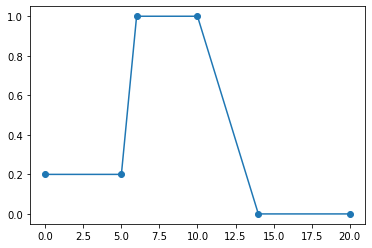

In [3]:
# DEMO

temperature_data = [1, 2, 2, 2, 3, 4, 5, 4, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
print(list(accumulate(temperature_data)))
phenology_params = calc_f_phen_from_sowing_day(
    temperature_data,
    sowing_day=3,
    t_sgs=5,
    t_egs=29,
    t_astart=22,
    t_aend=None,
    t_f_phen_1=23,
    t_f_phen_4=28,
    t_leaf_f_phen_1=27,
    t_leaf_f_phen_2=28,
    leaf_f_phen_a=30,
    leaf_f_phen_b=40,
    f_phen_a=0.2,
    f_phen_c=1,
    f_phen_e=0,
)

vals = [
    (0, phenology_params.f_phen_a),
    (phenology_params.SGS, phenology_params.f_phen_a),
    (phenology_params.SGS + phenology_params.f_phen_1, phenology_params.f_phen_c),
    (phenology_params.EGS - phenology_params.f_phen_4, phenology_params.f_phen_c),
    (phenology_params.EGS, phenology_params.f_phen_e),
    (20, phenology_params.f_phen_e),
]

plt.scatter(
    x=[i[0] for i in vals],
    y=[i[1] for i in vals],
)
plt.plot(
    [i[0] for i in vals],
    [i[1] for i in vals],
)
phenology_params


In [4]:


def calc_f_phen_from_mid_anthesis(
    temperature_data,
    mid_anthesis: int,
    t_mid_anthesis,
    t_sgs,
    t_egs,
    t_astart,
    t_aend,
    t_f_phen_1,
    t_f_phen_4,
    t_leaf_f_phen_1,
    t_leaf_f_phen_2,
    t_leaf_f_phen_a,
    t_leaf_f_phen_b,
    t_f_phen_a,
    t_f_phen_c,
    t_f_phen_e,
) -> PhenologyParameters:
    """Calculate the f_phen values from temperature data and mid anthesis.

    Converts temperature days to Julien days.

    Assumes dd = 0 is row 0.

    Parameters
    ----------
    mid_anthesis: int
        The day of mid anthesis [Julian day]
    t_mid_anthesis: float
        The thermal time at mid anthesis [deg C days]
    t_sgs: float
        The thermal time at SGS (f_phen_a) [deg C days]
    t_egs: float
        The thermal time at EGS (f_phen_d) [deg C days]
    t_astart: float
        The thermal time at Astart [deg C days]
    t_aend: float
        The thermal time at Aend [deg C days]
    t_f_phen_1: float
        The thermal time between f_phen_a(SGS) and f_phen_b [deg C days]
    t_f_phen_4: float
        The thermal time between f_phen_c and f_phen_d(EGS) [deg C days]
    t_leaf_f_phen_1: float
        The thermal time between leaf_f_phen_a and leaf_f_phen_b [deg C days] # TODO: CHECK LEAF FPHEN
    t_leaf_f_phen_2: float
        The thermal time between leaf_f_phen_c and leaf_f_phen_d [deg C days] # TODO: CHECK LEAF FPHEN
    leaf_f_phen_a: float
        leaf_f_phen at leaf_f_phen_a
    leaf_f_phen_b: float
        leaf_f_phen at leaf_f_phen_b
    f_phen_a: float
        f_phen at f_phen_a
    f_phen_c: float
        f_phen at f_phen_c
    f_phen_e: float
        f_phen at f_phen_e

    """
    start_day = 0
    end_day = len(temperature_data) - 1
    accumulated_temperatures = list(accumulate(temperature_data))
    mid_anthesis_t_acc = t_mid_anthesis or accumulated_temperatures[mid_anthesis]

    def next_t_acc(t_at): return next((
        dd
        for dd, t in enumerate(accumulated_temperatures)
        if t > mid_anthesis_t_acc - t_f_phen_4 + t_at))
    try:
        sowing_day = next_t_acc(0)
        return calc_f_phen_from_sowing_day(
            temperature_data,
            sowing_day,
            t_sgs,
            t_egs,
            t_astart,
            t_aend,
            t_f_phen_1,
            t_f_phen_4,
            t_leaf_f_phen_1,
            t_leaf_f_phen_2,
            t_leaf_f_phen_a,
            t_leaf_f_phen_b,
            t_f_phen_a,
            t_f_phen_c,
            t_f_phen_e,
        )
    except StopIteration as e:
        raise ValueError("f_phen values fall outside of input temperature data")


[1, 3, 5, 7, 10, 14, 19, 23, 27, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


PhenologyParameters(sowing_day=4, SGS=6, EGS=17, Astart=10, Aend=13, f_phen_1=1, f_phen_4=5, leaf_f_phen_1=11, leaf_f_phen_2=12, leaf_f_phen_a=30, leaf_f_phen_b=40, f_phen_a=0.2, f_phen_c=1, f_phen_e=0)

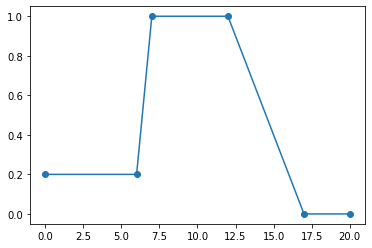

In [5]:


temperature_data = [1, 2, 2, 2, 3, 4, 5, 4, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
print(list(accumulate(temperature_data)))

phenology_params = calc_f_phen_from_mid_anthesis(
    temperature_data,
    mid_anthesis=12,
    t_sgs=5,
    t_egs=29,
    t_astart=22,
    t_aend=None,
    t_f_phen_1=23,
    t_f_phen_4=28,
    t_leaf_f_phen_1=27,
    t_leaf_f_phen_2=28,
    t_leaf_f_phen_a=30,
    t_leaf_f_phen_b=40,
    t_f_phen_a=0.2,
    t_f_phen_c=1,
    t_f_phen_e=0,
    t_mid_anthesis=None,
)

vals = [
    (0, phenology_params.f_phen_a),
    (phenology_params.SGS, phenology_params.f_phen_a),
    (phenology_params.SGS + phenology_params.f_phen_1, phenology_params.f_phen_c),
    (phenology_params.EGS - phenology_params.f_phen_4, phenology_params.f_phen_c),
    (phenology_params.EGS, phenology_params.f_phen_e),
    (20, phenology_params.f_phen_e),
]

plt.scatter(
    x=[i[0] for i in vals],
    y=[i[1] for i in vals],
)
plt.plot(
    [i[0] for i in vals],
    [i[1] for i in vals],
)

phenology_params

In [6]:
# Test with real data


# phenology_params = calc_f_phen_from_mid_anthesis(
#     temperature_data,
#     t_mid_anthesis=1075,
#     t_sgs=70,
#     t_egs=1845,
#     t_astart=945,
#     t_aend=1845,
#     t_f_phen_1=350,
#     t_f_phen_4=1075,
#     t_f_phen_a=0.2,
#     t_f_phen_c=1.0,
#     t_f_phen_e=0.0,
#     mid_anthesis=None,
#     t_leaf_f_phen_1=
# )

In [7]:


def calc_f_phen_data_from_t_f_phen(
    temperature_data,
    t_f_phen_a,
    t_f_phen_b,
    t_f_phen_c,
    t_f_phen_d,
    f_phen_min,
) -> List[float]:
    """Calculate the f_phen values from temperature data and mid anthesis.

    Converts temperature days to Julien days.

    Assumes dd = 0 is row 0.

    Parameters
    ----------
    temperature_data: List[float]
        Temperature data [DegC]
        t_f_phen_a: float
            thermal time between sowing day and f_phen_a [degC days]
        t_f_phen_b: float
            thermal time between sowing day and f_phen_b [degC days]
        t_f_phen_c: float
            thermal time between sowing day and f_phen_c [degC days]
        t_f_phen_d: float
            thermal time between sowing day and f_phen_d [degC days]
        f_phen_min: float
            thermal time between sowing day and phen_min [fraction]

    """
    accumulated_temperatures = list(accumulate(temperature_data))

    def _get_f_phen(td):
        if td < t_f_phen_a:
            return f_phen_min
        if td < t_f_phen_b:
            return (1 - f_phen_min) * ((td - t_f_phen_a) / (t_f_phen_b - t_f_phen_a)) + f_phen_min
        if td < t_f_phen_c:
            return 1
        if td < t_f_phen_d:
            return (1 - f_phen_min) * (t_f_phen_d - td) / (t_f_phen_d - t_f_phen_c) + f_phen_min
        if td >= t_f_phen_d:
            return 0

    f_phen = list(map(_get_f_phen, accumulated_temperatures))
    return f_phen



Text(1845, 1.1, 't_f_phen_d')

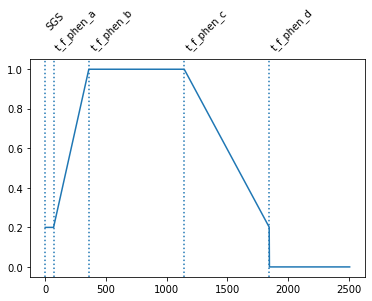

In [8]:
demo_temp_data = [2 for _ in range(1253)]
accumulated_temperatures = list(accumulate(demo_temp_data))

t_f_phen_a = 70
t_f_phen_b = 360
t_f_phen_c = 1145
t_f_phen_d = 1845
f_phen_min = 0.2
f_phen_data = calc_f_phen_data_from_t_f_phen(
    demo_temp_data,
    t_f_phen_a=t_f_phen_a,
    t_f_phen_b=t_f_phen_b,
    t_f_phen_c=t_f_phen_c,
    t_f_phen_d=t_f_phen_d,
    f_phen_min=f_phen_min,
)


plt.plot(accumulated_temperatures, f_phen_data)
plt.axvline(0, linestyle='dotted')
plt.axvline(t_f_phen_a, linestyle='dotted')
plt.axvline(t_f_phen_b, linestyle='dotted')
plt.axvline(t_f_phen_c, linestyle='dotted')
plt.axvline(t_f_phen_d, linestyle='dotted')
plt.text(0, 1.2, 'SGS', rotation=45)
plt.text(t_f_phen_a, 1.1, 't_f_phen_a', rotation=45)
plt.text(t_f_phen_b, 1.1, 't_f_phen_b', rotation=45)
plt.text(t_f_phen_c, 1.1, 't_f_phen_c', rotation=45)
plt.text(t_f_phen_d, 1.1, 't_f_phen_d', rotation=45)

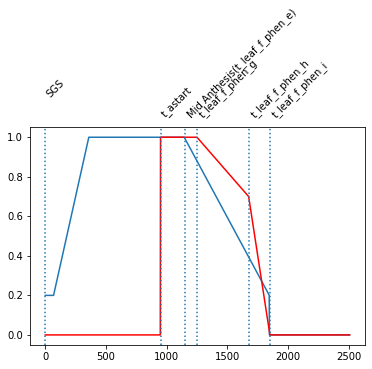

In [9]:


def calc_leaf_f_phen_from_t_leaf_f_phen(
    temperature_data,
    t_leaf_f_phen_a,
    t_leaf_f_phen_b,
    t_leaf_f_phen_e,
    t_leaf_f_phen_g,
    t_leaf_f_phen_h,
    t_leaf_f_phen_i,
    t_astart,
) -> List[float]:
    """Calculate the leaf f phen from temperature data.

    Parameters
    ----------
    temperature_data : [type]
        External temperature data [deg C]
    t_leaf_f_phen_a : float
        Gradient of descent during seed setting [fraction]
    t_leaf_f_phen_b : float
        Gradient of descent during senescence [fraction]
    t_leaf_f_phen_e : float
        Thermal time between Astart and leaf_f_phen_e(Mid anthesis) [DegC Days]
    t_leaf_f_phen_g : float
        Thermal time between Mid Anthesis and start of seed setting [DegC Days]
    t_leaf_f_phen_h : float
        Thermal time between Mid anthesis and start of senesence [DegC Days]
    t_leaf_f_phen_i : float
        Thermal time between Mid anthesis and end of senescence [DegC Days]
    t_astart : float
        Thermal time between Sowing day and Astart [DegC Days]

    Returns
    -------
    [type]
        [description]
    """
    accumulated_temperatures = list(accumulate(temperature_data))

    def _get_f_phen(td):
        """For each row of data compare the current thermal time against leaf_f_fphen parameters."""
        td_a = td - t_leaf_f_phen_e - t_astart
        if td_a < -t_leaf_f_phen_e:
            return 0
        if td_a <= t_leaf_f_phen_g:
            return 1
        if td_a > t_leaf_f_phen_g and td_a <= t_leaf_f_phen_h:
            return 1 - t_leaf_f_phen_a / (t_leaf_f_phen_h - t_leaf_f_phen_g) * (td_a - t_leaf_f_phen_g)
        if td_a > t_leaf_f_phen_h and td_a <= t_leaf_f_phen_i:
            return t_leaf_f_phen_b - t_leaf_f_phen_b / (t_leaf_f_phen_i - t_leaf_f_phen_h) * (td_a - t_leaf_f_phen_h)
        else:
            return 0

    leaf_f_phen = list(map(_get_f_phen, accumulated_temperatures))
    return leaf_f_phen


t_leaf_f_phen_a = 0.3
t_leaf_f_phen_b = 0.7
t_leaf_f_phen_e = 200
t_leaf_f_phen_g = 100
t_leaf_f_phen_h = 525
t_leaf_f_phen_i = 700
t_astart = 950
leaf_f_phen_data = calc_leaf_f_phen_from_t_leaf_f_phen(
    demo_temp_data,
    t_leaf_f_phen_a=t_leaf_f_phen_a,
    t_leaf_f_phen_b=t_leaf_f_phen_b,
    t_leaf_f_phen_e=t_leaf_f_phen_e,
    t_leaf_f_phen_g=t_leaf_f_phen_g,
    t_leaf_f_phen_h=t_leaf_f_phen_h,
    t_leaf_f_phen_i=t_leaf_f_phen_i,
    t_astart=t_astart,
)

plt.plot(accumulated_temperatures, f_phen_data)
plt.plot(accumulated_temperatures, leaf_f_phen_data, color="red")
plt.axvline(0, linestyle='dotted')
plt.axvline(t_astart + t_leaf_f_phen_e, linestyle='dotted')
plt.axvline(t_astart + t_leaf_f_phen_e + t_leaf_f_phen_g, linestyle='dotted')
plt.axvline(t_astart + t_leaf_f_phen_e + t_leaf_f_phen_h, linestyle='dotted')
plt.axvline(t_astart + t_leaf_f_phen_e + t_leaf_f_phen_i, linestyle='dotted')
plt.axvline(t_astart, linestyle='dotted')
plt.text(0, 1.2, 'SGS', rotation=45)
plt.text(t_astart + t_leaf_f_phen_e, 1.1, 'Mid Anthesis(t_leaf_f_phen_e)', rotation=45)
plt.text(t_astart + t_leaf_f_phen_e + t_leaf_f_phen_g, 1.1, 't_leaf_f_phen_g', rotation=45)
plt.text(t_astart + t_leaf_f_phen_e + t_leaf_f_phen_h, 1.1, 't_leaf_f_phen_h', rotation=45)
plt.text(t_astart + t_leaf_f_phen_e + t_leaf_f_phen_i, 1.1, 't_leaf_f_phen_i', rotation=45)
plt.text(t_astart, 1.1, 't_astart', rotation=45)
plt.show()